In [ ]:
!pip install catboost
!pip install mplsoccer
!pip install koreanize-matplotlib
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [6]:
import pandas as pd
import os
import numpy as np
import math
from tqdm import tqdm
from pathlib import Path
from mplsoccer import Pitch

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
import matplotlib.patches as mpatches

import seaborn as sns

from matplotlib import font_manager, rc
import koreanize_matplotlib


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir('/content/drive/MyDrive/Kleage')
os.getcwd()

'/content/drive/MyDrive/Kleage'

## 피처 엔지니어링

### 데이터 로드 train/test

In [ ]:
# Train 원본 로딩
train_df = pd.read_csv("./data/train.csv")
train_df = train_df.sort_values(["game_episode", "time_seconds"]).reset_index(drop=True)
train_df["is_train"] = 1

# Test 원본 로딩
root = Path("./data")
test_meta = pd.read_csv(root / "test.csv")
test_meta["path"] = test_meta["path"].str.replace("./test/", "./data/test/", regex=False)

episode_dfs = []

for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    ep_df = pd.read_csv(row["path"]).reset_index(drop=True)
    ep_df["game_id"] = row["game_id"]
    ep_df["game_episode"] = row["game_episode"]
    ep_df["is_train"] = 0
    episode_dfs.append(ep_df)

test_df = pd.concat(episode_dfs, ignore_index=True)
print(train_df.shape, test_df.shape)

# train + test 병합
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.shape)

use_cols = [
    'game_id',
    'game_day', 'game_date',
    'home_score', 'away_score',
    'venue',
    'home_team_name_ko', 'away_team_name_ko'   # EDA용
]

# match_info 병합
df_match = pd.read_csv("./data/match_info.csv")
df_copy = df.merge(df_match[use_cols], on='game_id', how='left')

100%|██████████| 2414/2414 [00:11<00:00, 208.21it/s]


(356721, 16) (53110, 16)
(409831, 16)


In [ ]:
# 대분류 game_episode(게임 ID + 전ㆍ후반)  / 중분류 time_seconds : 동에피소드 시간순서
if 'type_name' in df_copy.columns:
    df_copy = df_copy.rename(columns={'type_name': 'action_type'})
print("train/test + match_info 병합 = df_copy")
print(df_copy.info())

train/test + match_info 병합 = df_copy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409831 entries, 0 to 409830
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            409831 non-null  int64  
 1   period_id          409831 non-null  int64  
 2   episode_id         409831 non-null  int64  
 3   time_seconds       409831 non-null  float64
 4   team_id            409831 non-null  int64  
 5   player_id          409831 non-null  int64  
 6   action_id          409831 non-null  int64  
 7   action_type        409831 non-null  object 
 8   result_name        248448 non-null  object 
 9   start_x            409831 non-null  float64
 10  start_y            409831 non-null  float64
 11  end_x              407417 non-null  float64
 12  end_y              407417 non-null  float64
 13  is_home            409831 non-null  bool   
 14  game_episode       409831 non-null  object 
 15  is_train      

### 선수 포지션 클러스터링

['Pass' 'Pass_Corner' 'Goal Kick' 'Throw-In' 'Pass_Freekick']


<Figure size 1000x800 with 0 Axes>

,count
player_role_label,
left_wing,146507
defence,113553
right_wing,65619
attack,59961
mid,23521
unknown,670


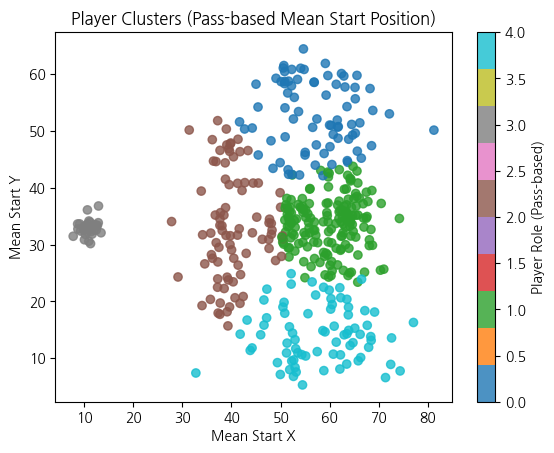

In [ ]:
# 0. Pass 이벤트만
pass_events = ["Pass", "Pass_Freekick", "Pass_Corner", "Throw-In", "Goal Kick"]
df_pass = df_copy[(df_copy["is_train"] == 1) & (df_copy["action_type"].isin(pass_events))].copy()
print(df_pass['action_type'].unique())

df_pass["dx"] = df_pass["end_x"] - df_pass["start_x"]
df_pass["dy"] = df_pass["end_y"] - df_pass["start_y"]
df_pass["pass_dist"] = np.sqrt(df_pass["dx"]**2 + df_pass["dy"]**2)
df_pass["forward"] = (df_pass["dx"] > 0).astype(int)
df_pass["side_move"] = df_pass["dy"].abs()

# 1. 패스 개수 너무 적은 선수 제거
pass_counts = df_pass.groupby("player_id").size()
valid_players = pass_counts[pass_counts >= 5].index

df_pass_valid = df_pass[df_pass["player_id"].isin(valid_players)].copy()

# 2. player_stats 다시 계산
player_stats = df_pass_valid.groupby("player_id").agg({
    "start_x": ["mean"],
    "start_y": ["mean"],
    "end_x": ["mean"],
    "end_y": ["mean"],
    "dx": ["mean"],
    "dy": ["mean"],
    "pass_dist": ["mean", "std"],
    "forward": "mean",
    "side_move": "mean",
})

# 3. MultiIndex 컬럼 평탄화 + NaN 처리
player_stats_flat = player_stats.copy()
player_stats_flat.columns = ['_'.join(col).strip() for col in player_stats_flat.columns.values]

# NaN 채우기 (std 같은 데서 생긴 NaN)
player_stats_flat = player_stats_flat.fillna(0)

# 4. KMeans 클러스터링
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
player_role_labels = kmeans.fit_predict(player_stats_flat)

# player_id -> role 매핑
id2role = dict(zip(player_stats_flat.index, player_role_labels))

# 5. 원본 df에 role 붙이기 (패스 적은 선수는 NaN이 들어감)
df_copy["player_role_pass"] = df_copy["player_id"].map(id2role)

# 6. 시각화: 평균 시작 위치 기준
player_loc = df_pass_valid.groupby("player_id")[["start_x", "start_y"]].mean()
player_loc["player_role_pass"] = player_loc.index.map(id2role)

plt.figure(figsize=(10,8))
plt.show()
scatter = plt.scatter(
    player_loc["start_x"],
    player_loc["start_y"],
    c=player_loc["player_role_pass"],
    cmap="tab10",
    alpha=0.8
)

plt.colorbar(scatter, label="Player Role (Pass-based)")
plt.xlabel("Mean Start X")
plt.ylabel("Mean Start Y")
plt.title("Player Clusters (Pass-based Mean Start Position)")
plt.gca().invert_yaxis

# Pass 데이터에 클러스터 라벨 붙이기
df_pass_valid["player_role_pass"] = df_pass_valid["player_id"].map(id2role)

cluster_summary = df_pass_valid.groupby("player_role_pass").agg({
    "start_x": "mean",
    "start_y": "mean",
    "end_x": "mean",
    "end_y": "mean",
    "dx": "mean",
    "dy": "mean",
    "pass_dist": ["mean", "std"],
    "forward": "mean",
    "side_move": "mean",
    "player_id": "nunique"  # 클러스터 내 선수 수
})

player_profile = df_pass_valid.groupby("player_id").agg({
    "start_x": "mean",
    "start_y": "mean",
    "end_x": "mean",
    "end_y": "mean",
    "pass_dist": "mean",
    "forward": "mean",
    "side_move": "mean"
})

# 1) cluster → 역할명 매핑
role_map = {
    0: "right_wing",
    1: "left_wing",
    2: "defence",
    3: "mid",
    4: "attack"
}

# 2) player_id → cluster 번호 매핑
id2cluster = df_pass_valid.groupby("player_id")["player_role_pass"].first().to_dict()

# 3) player_id → 역할명 매핑
id2role_label = {pid: role_map[id2cluster[pid]] for pid in id2cluster}

# 4) df에 새로운 역할 컬럼 추가
df_copy["player_role_label"] = df_copy["player_id"].map(id2role_label)

# 5) 매핑 안 된 n명(31명) unknown으로 처리
df_copy["player_role_label"] = df_copy["player_role_label"].fillna("unknown")

df_copy['player_role_label'].value_counts()

### lag feature 구현(이전 좌표, 이벤트 타입, 결과)

In [ ]:
# 0) 에피소드 내 시간 순으로 정렬
order_col = "time_seconds"   # 또는 "action_id"
df_copy = df_copy.sort_values(["game_episode", order_col]).copy()

# 1) 몇 개 이전까지 볼지 설정
n_prev = 1

# 2) 이전 이벤트에서 가져올 컬럼들
base_cols = ["end_x", "end_y",'action_type', "result_name"]

for i in range(1, n_prev + 1):
    shifted = (
        df_copy
        .groupby("game_episode")[base_cols]
        .shift(i)        # i번째 이전 이벤트
    )

    # 컬럼 이름 붙이기
    shifted.columns = [f"prev{i}_{col}" for col in base_cols]

    # 원본 df_copy에 붙이기
    df_copy = pd.concat([df_copy, shifted], axis=1)

# # 3) result_name 계열 NaN 처리
# df_copy["result_name"] = df_copy["result_name"].fillna("NoResult")
# df_copy["prev1_result_name"] = df_copy["prev1_result_name"].fillna("NoPrev")

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,away_score,venue,home_team_name_ko,away_team_name_ko,player_role_pass,player_role_label,prev1_end_x,prev1_end_y,prev1_action_type,prev1_result_name
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,NaN,NaN,NaN,NaN
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,defence,31.322445,38.274752,Pass,Successful
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,37.371285,30.632980,Pass,Successful
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,1.0,left_wing,38.391570,24.613144,Carry,NaN
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,4.0,attack,34.573350,5.545468,Pass,Successful


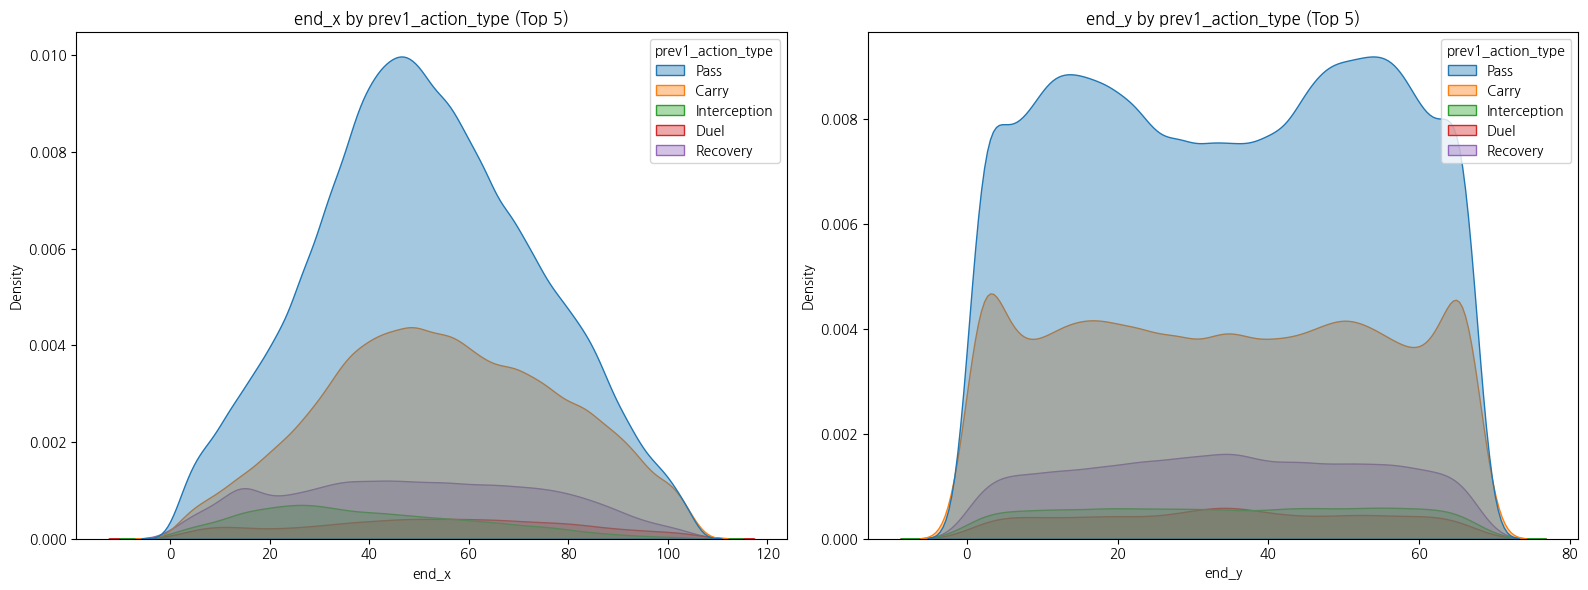

In [ ]:
# df_copy 1-step의 상위 5개의 type_name의 행동 분포확인
# Top 5 prev1_action_type 선택
topN = df_copy["prev1_action_type"].value_counts().head(5).index.tolist()
plot = df_copy[df_copy["prev1_action_type"].isin(topN)]

# Figure & subplots 준비
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) end_x KDE
sns.kdeplot(
    data=plot, x="end_x", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[0]
)
axes[0].set_title("end_x by prev1_action_type (Top 5)")

# 2) end_y KDE
sns.kdeplot(
    data=plot, x="end_y", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[1]
)
axes[1].set_title("end_y by prev1_action_type (Top 5)")

plt.tight_layout()
plt.show()

### 행동 패턴 추가

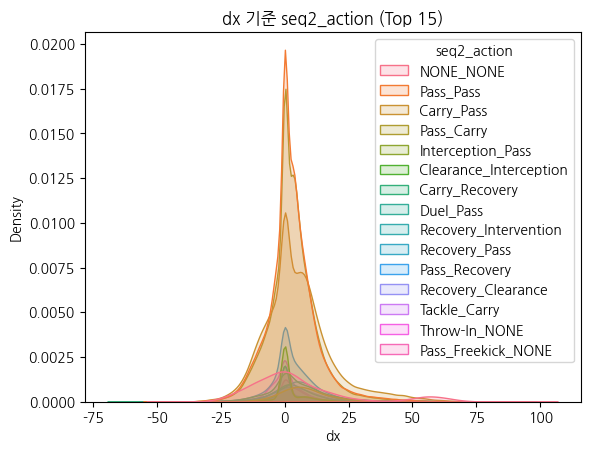

In [ ]:
#1-step + 2-step 조합
df_copy["prev2_action_type"] =df_copy.groupby("game_episode")["action_type"].shift(2)

df_copy["prev1_action_type"]  = df_copy["prev1_action_type"].fillna("NONE")
df_copy["prev2_action_type"] = df_copy["prev2_action_type"].fillna("NONE")

df_copy["seq2_action"] = df_copy["prev1_action_type"] + "_" + df_copy["prev2_action_type"]

# 행동에 따른 이동 패턴
df_copy["dx"] = df_copy["end_x"] - df_copy["start_x"]
df_copy["dy"] = df_copy["end_y"] - df_copy["start_y"]

# seq2_action 상위 15개 분포 확인 (dx기준)
topK = df_copy["seq2_action"].value_counts().head(15).index.tolist()
df_top = df_copy[df_copy["seq2_action"].isin(topK)]
sns.kdeplot(data=df_top, x="dx", hue="seq2_action", fill=True, alpha=0.2)
plt.title('dx 기준 seq2_action (Top 15)')
plt.show()

# seq2_action_top 변수 df에 추가
df_copy["seq2_action_top"] = df_copy["seq2_action"].where(df_copy["seq2_action"].isin(topK), "OTHER")

#사용안하는 변수 삭제
df_copy = df_copy.drop(columns=["dx", "dy", "seq2_action"])

### 수치 데이터 추가

In [ ]:
# 2. DL/Goal/Penalty Features 추가
def add_dl_features(df):
    # 이전 시작 위치
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    dx = df['start_x'] - df['prev_start_x'] # Series
    dy = df['start_y'] - df['prev_start_y'] # Series

    # 현재 시간 - 과거 시간
    dt = df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)
    dt = dt.fillna(1.0).replace(0, 0.1)

    # 속도 계산
    df['legal_speed'] = np.sqrt(dx**2 + dy**2) / dt
    df['legal_speed'] = df['legal_speed'].fillna(0.0)
    #print("50m/s 초과하는 이상치 개수:", (df['legal_speed'] > 50).sum())
    #df.loc[df['legal_speed'] > 50, 'legal_speed'] = 50

    # 각도 없이 속도만 넣을 경우 predict = 16m
    # 각도 포함하여 계산할 경우 16 -> 14.05까지 Down
    df['move_angle'] = np.arctan2(dy, dx)
    df['move_angle_sin'] = np.sin(df['move_angle']).fillna(0.0)
    df['move_angle_cos'] = np.cos(df['move_angle']).fillna(0.0)

    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)
    df['y_lane'] = pd.cut(
        df['start_y'],
        bins=[0, 68/3, 2*68/3, 68],
        labels=[0, 1, 2],
        include_lowest=True
    ).astype(int)

    # Goal Value 패널티 박스 플레이 가정
    OPP_GOAL_X, OPP_GOAL_Y = 105, 34
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - OPP_GOAL_X)**2 + (df['start_y'] - OPP_GOAL_Y)**2)
    df['angle_to_opp_goal'] = np.arctan2(OPP_GOAL_Y - df['start_y'], OPP_GOAL_X - df['start_x'])
    df['angle_to_opp_goal_sin'] = np.sin(df['angle_to_opp_goal']).fillna(0.0)
    df['angle_to_opp_goal_cos'] = np.cos(df['angle_to_opp_goal']).fillna(0.0)

    PENALTY_LINE_X = 105 - 16.5  # 88.5m
    PENALTY_CENTER_Y = 34
    df['dist_to_opp_box_center'] = np.sqrt(
        (df['start_x'] - PENALTY_LINE_X)**2 + (df['start_y'] - PENALTY_CENTER_Y)**2
    )

    # 추가: 에피소드 내 이벤트 순번 (0, 1, 2, ...)
    df['episode_event_index'] = df.groupby('game_episode').cumcount()

    return df

df_copy = add_dl_features(df_copy)

# 실제 시간 추가
df_copy["match_minutes"] = df_copy["time_seconds"]/60 + (df_copy["period_id"]-1)*45

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0.000000,3,1,52.584313,0.009786,0.009785,0.999952,36.085464,0,0.011117
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,-0.975361,2,1,73.101872,-0.056127,-0.056097,0.998425,56.635419,1,0.061117
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0.582957,2,1,67.712480,0.049746,0.049725,0.998763,51.239461,2,0.082800
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0.167104,2,1,67.266604,0.140004,0.139547,0.990215,50.980073,3,0.136667
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,-0.201285,2,0,75.762127,0.377727,0.368809,0.929505,60.730940,4,0.193883


In [ ]:
# =============================================================================
# 1. 공간 및 지역 피처 (Spatial & Zone Features)
# 의도: 현재 공의 위치가 경기장의 어느 구역이며, 골대와 얼마나 인접해 있는가?
# =============================================================================
def add_spatial_features(df):
    # [구역화] 경기장 가로(105m)를 7등분: 0(우리쪽 골대) ~ 6(상대쪽 골대)
    # 어떤 지역에서 패스가 주로 시작되는지 파악
    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)

    # [레인화] 경기장 세로(68m)를 3등분: 0(좌측), 1(중앙), 2(우측)
    # 측면 공격인지 중앙 빌드업인지 구분
    df['y_lane'] = pd.cut(df['start_y'], bins=[0, 68/3, 2*68/3, 68],
                          labels=[0, 1, 2], include_lowest=True).astype(int)

    # [공격 거리] 상대 골대 중앙(105, 34)까지의 직선 거리
    # 거리가 가까울수록 슛이나 결정적인 패스 확률 증가
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - 105)**2 + (df['start_y'] - 34)**2)

    # [수비 거리] 우리 골대 중앙(0, 34)까지의 직선 거리
    # 우리 진영 깊숙한 곳인지 확인 (위험 지역에서의 빌드업 판단)
    df['dist_to_my_goal'] = np.sqrt((df['start_x'] - 0)**2 + (df['start_y'] - 34)**2)

    # [박스 타겟] 상대 패널티 박스 정면(88.5, 34)과의 거리
    # 찬스 메이킹이 일어나는 핵심 지역과의 인접도
    df['dist_to_opp_box_center'] = np.sqrt((df['start_x'] - 88.5)**2 + (df['start_y'] - 34)**2)

    # [사이드라인] 현재 위치에서 가장 가까운 터치라인까지의 거리
    # 압박을 받기 쉬운 가장자리인지, 자유로운 중앙인지 판단
    df['dist_to_sideline'] = df['start_y'].apply(lambda y: min(y, 68 - y))

    return df

# =============================================================================
# 2. 물리 및 동적 흐름 피처 (Physics & Flow Features)
# 의도: 이전 동작으로부터 현재까지 공과 선수가 어떻게 이동(가속/방향전환)했는가?
# =============================================================================
def add_physics_features(df):
    # [직전 좌표] 바로 직전 이벤트의 시작 위치를 가져옴
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    # [변위] 이전 위치에서 현재 위치까지의 x, y축 이동 거리
    dx = df['start_x'] - df['prev_start_x']
    dy = df['start_y'] - df['prev_start_y']

    # [시간차] 이벤트 사이의 경과 시간 (나눗셈 에러 방지를 위해 최소 0.1초 설정)
    dt = (df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)).fillna(1.0).replace(0, 0.1)

    # [이동 속도] 단위 시간당 이동 거리 (m/s)
    # 역습 상황처럼 빠르게 전진 중인지, 지공 상황인지 구분
    df['legal_speed'] = (np.sqrt(dx**2 + dy**2) / dt).fillna(0.0)

    # [이동 각도] 현재 이동 중인 방향을 라디안 각도로 계산
    move_angle = np.arctan2(dy, dx)
    # [각도 분해] 모델이 각도의 연속성을 이해하도록 Sin/Cos 값으로 변환
    # (예: 359도와 1도는 수치상 멀지만 물리적으론 가깝기 때문)
    df['move_angle_sin'] = np.sin(move_angle).fillna(0.0)
    df['move_angle_cos'] = np.cos(move_angle).fillna(0.0)

    return df

# =============================================================================
# 3. 과거 맥락(Lag) 피처 (Sequence Context Features)
# 의도: 지금 패스하기 직전 3단계 동안 어떤 일이 있었는가? (흐름 파악)
# =============================================================================
def add_lag_features(df, n_shifts=3):
    # 추적 항목: 종료 위치(x, y), 행동 종류(action), 성공 여부(result)
    base_cols = ["end_x", "end_y", "action_type", "result_name"]
    grp = df.groupby("game_episode")

    for k in range(1, n_shifts + 1):
        # [과거 데이터] k단계 전의 기록을 현재 시점으로 당겨옴
        shifted = grp[base_cols].shift(k)
        shifted.columns = [f"prev{k}_{c}" for c in base_cols]
        df = pd.concat([df, shifted], axis=1)

        # [결측 보정] 에피소드 시작 시점이라 과거가 없다면 현재 시작 위치로 채움
        df[f'prev{k}_end_x'] = df[f'prev{k}_end_x'].fillna(df['start_x'])
        df[f'prev{k}_end_y'] = df[f'prev{k}_end_y'].fillna(df['start_y'])

    return df

# =============================================================================
# 4. 에피소드 누적 피처 (Episode Aggregation Features)
# 의도: 이번 공격권(에피소드) 내에서 팀이 보여준 전체적인 데이터 요약
# =============================================================================
def add_agg_features(df):
    grp = df.groupby("game_episode")

    # [진행 순서] 에피소드 내 현재 행동의 인덱스 (초반 빌드업인지 후반부인지)
    df['episode_event_index'] = grp.cumcount()

    # [총 행동수] 이번 에피소드에서 총 몇 번의 터치가 일어났는지 (공격의 길이)
    df['episode_len'] = grp['action_id'].transform('count')

    # [패스 횟수] 현재 에피소드 내 누적 패스 성공 횟수 (팀의 패스 성향)
    df['n_pass'] = grp['action_type'].transform(lambda x: (x == 'Pass').sum())

    # [드리블 횟수] 현재 에피소드 내 누적 드리블(Carry) 횟수 (개인 전술 비중)
    df['n_carry'] = grp['action_type'].transform(lambda x: (x == 'Carry').sum())

    return df

In [ ]:
df_copy["prev1_dx"] = df_copy["prev1_end_x"] - df_copy["start_x"]
df_copy["prev1_dy"] = df_copy["prev1_end_y"] - df_copy["start_y"]
df_copy["prev1_dist"] = np.sqrt(df_copy["prev1_dx"]**2 + df_copy["prev1_dy"]**2)

theta = np.arctan2(df_copy["prev1_dy"], df_copy["prev1_dx"])
df_copy["prev1_angle_sin"] = np.sin(theta)
df_copy["prev1_angle_cos"] = np.cos(theta)

## 모델 실험 및 추론

### 데이터 확인

In [ ]:
df_copy.columns

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'action_type', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode', 'is_train',
       'game_day', 'game_date', 'home_score', 'away_score', 'venue',
       'home_team_name_ko', 'away_team_name_ko', 'player_role_pass',
       'player_role_label', 'prev1_end_x', 'prev1_end_y', 'prev1_action_type',
       'prev1_result_name', 'prev2_action_type', 'seq2_action_top',
       'prev_start_x', 'prev_start_y', 'legal_speed', 'move_angle',
       'move_angle_sin', 'move_angle_cos', 'x_zone', 'y_lane',
       'dist_to_opp_goal', 'angle_to_opp_goal', 'angle_to_opp_goal_sin',
       'angle_to_opp_goal_cos', 'dist_to_opp_box_center',
       'episode_event_index', 'match_minutes', 'p_cnt', 'p_mean_r', 'p_std_r',
       'p_mean_dx', 'p_mean_dy'],
      dtype='object')

In [ ]:
df_copy.isnull().sum()

,0
game_id,0
period_id,0
episode_id,0
time_seconds,0
team_id,0
player_id,0
action_id,0
action_type,0
result_name,161383
start_x,0


In [ ]:
#패스가 없는 선수는 평균적인 선수의 값으로 null값 채우기 -> 추가!!!!!!11
# 전체 평균 (train 기준으로 이미 계산된 값)
global_mean_r  = df_copy.loc[df_copy["is_train"] == 1, "p_mean_r"].mean()
global_std_r   = df_copy.loc[df_copy["is_train"] == 1, "p_std_r"].mean()
global_mean_dx = df_copy.loc[df_copy["is_train"] == 1, "p_mean_dx"].mean()
global_mean_dy = df_copy.loc[df_copy["is_train"] == 1, "p_mean_dy"].mean()

# NaN 채우기
df_copy["p_mean_r"]  = df_copy["p_mean_r"].fillna(global_mean_r)
df_copy["p_std_r"]   = df_copy["p_std_r"].fillna(global_std_r)
df_copy["p_mean_dx"] = df_copy["p_mean_dx"].fillna(global_mean_dx)
df_copy["p_mean_dy"] = df_copy["p_mean_dy"].fillna(global_mean_dy)


### 데이터 전처리

In [ ]:
DROP_COLS = [
    # ID / 메타
    "game_id", 'period_id', "episode_id", "game_episode",
    'time_seconds', 'is_train',
    "action_id", "team_id", "player_id",
    "venue", "game_day", 'game_date', 'home_team_name_ko',
    'away_team_name_ko', 'is_home',

    # 스코어 (미래 정보 가능)
    "home_score", "away_score",

    # 중간 계산 / 제거 결정
    "prev_start_x", "prev_start_y",
    "move_angle","angle_to_opp_goal",
    'dist_to_opp_box_center',
    "period_id", "action_type", 'prev2_action_type'
]

### 피처 추가시 여기에 추가 ###
FEATURE_CANDIDATES = [
    # ===== 시간 / 순서 =====
    "match_minutes",
    "episode_event_index",
    "seq2_action_top",

    # ===== 위치/이동=====
    "start_x", "start_y","legal_speed",
    "move_angle_sin", "move_angle_cos",

    # ===== lag 정보 =====
    "prev1_end_x", "prev1_end_y",

    # ===== 공간 구역 =====
    "x_zone", "y_lane",

    # ===== 골 기준 =====
    "dist_to_opp_goal",
    "angle_to_opp_goal_sin", "angle_to_opp_goal_cos",

    # ===== 이벤트 =====
    "result_name",
    "prev1_action_type",
    "prev1_result_name",

    # ===== 역할 =====
    "player_role_label", 'player_role_pass',

    # ==== 추가 ====
    'prev1_dx', 'prev1_dy', 'prev1_dist', 'prev1_angle_sin', 'prev1_angle_cos',
    'wing_prev_dy', 'wing_prev_angle_sin', 'wing_prev_angle_cos',
    'p_mean_r', 'p_std_r', 'p_mean_dx', 'p_mean_dy' #side
]

CAT_CANDIDATES = [
    "result_name",
    "player_role_label",
    "seq2_action_top",
    "prev1_action_type",
    "prev1_result_name",
    "x_zone", "y_lane",
    "player_role_pass",
]

SORT_KEYS = ["game_episode", "time_seconds", "action_id"]
TARGETS = ["end_x", "end_y"]

In [ ]:
# 전처리 & 학습 함수 정의
def add_episode_len(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["episode_len"] = df.groupby("game_episode")["action_id"].transform("count")
    return df

def split_train_test(df: pd.DataFrame, flag_col="is_train"):
    df_train = df[df[flag_col] == 1].copy()
    df_test  = df[df[flag_col] == 0].copy()
    return df_train, df_test

def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(SORT_KEYS).reset_index(drop=True)

def get_last_event_per_episode(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.sort_values(SORT_KEYS)
          .groupby("game_episode", as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )

def filter_train_targets(df: pd.DataFrame) -> pd.DataFrame:
    cond = df["end_x"].notnull() & df["end_y"].notnull()
    return df[cond].reset_index(drop=True)

def build_feature_cols(df: pd.DataFrame) -> list:
    # 존재하는 컬럼만 + 드랍 대상 제거 + 중복 제거
    cols = [c for c in FEATURE_CANDIDATES if c in df.columns]
    cols = [c for c in cols if c not in DROP_COLS]
    return list(dict.fromkeys(cols))

def build_cat_features(feature_cols: list) -> list:
    return [c for c in CAT_CANDIDATES if c in feature_cols]

def fill_missing(X_train: pd.DataFrame, X_test: pd.DataFrame, cat_features: list):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    # 범주형: 문자열화 + Missing
    for c in cat_features:
        X_train[c] = X_train[c].astype(str).fillna("Missing")
        X_test[c]  = X_test[c].astype(str).fillna("Missing")

    # numeric (의미상 0이 안전한 것만)
    for c in ["dx", "dy", "legal_speed"]:
        if c in X_train.columns:
            X_train[c] = X_train[c].fillna(0.0)
            X_test[c]  = X_test[c].fillna(0.0)

    return X_train, X_test

In [ ]:
# 메인 전처리
def build_datasets(df_copy: pd.DataFrame):
    df = add_episode_len(df_copy)

    df_train, df_test = split_train_test(df, "is_train")
    df_train, df_test = sort_df(df_train), sort_df(df_test)

    train_epi = filter_train_targets(get_last_event_per_episode(df_train))
    test_epi  = get_last_event_per_episode(df_test)

    feature_cols  = build_feature_cols(train_epi)
    cat_features  = build_cat_features(feature_cols)

    X_train = train_epi[feature_cols].copy()
    X_test  = test_epi[feature_cols].copy()

    X_train, X_test = fill_missing(X_train, X_test, cat_features)

    y_x = train_epi["end_x"].values
    y_y = train_epi["end_y"].values

    meta = {
        "train_rows": df_train.shape,
        "test_rows": df_test.shape,
        "train_episodes": len(train_epi),
        "test_episodes": len(test_epi),
        "n_features": len(feature_cols),
        "feature_cols": feature_cols,
        "cat_features": cat_features,
    }
    return X_train, X_test, y_x, y_y, train_epi, test_epi, meta

# 실행
X_train_full, X_test_full, y_x, y_y, train_epi, test_epi, meta = build_datasets(df_copy)

cat_features = meta["cat_features"]
feature_cols = meta["feature_cols"]

print("train rows:", meta["train_rows"], "test rows:", meta["test_rows"])
print("train episodes:", meta["train_episodes"], "test episodes:", meta["test_episodes"])
print("X_train shape:", X_train_full.shape)         # 실제 train shape
print("len(feature_cols):", len(feature_cols))      # 실제 사용 피처 개수
print("features:", meta["feature_cols"])            # 실제 사용 피처
print("cat_features:", meta["cat_features"])        # 실제 사용 범주형 피처

train rows: (356721, 52) test rows: (53110, 52)
train episodes: 15435 test episodes: 2414
X_train shape: (15435, 24)
len(feature_cols): 24
features: ['match_minutes', 'episode_event_index', 'seq2_action_top', 'start_x', 'start_y', 'legal_speed', 'move_angle_sin', 'move_angle_cos', 'prev1_end_x', 'prev1_end_y', 'x_zone', 'y_lane', 'dist_to_opp_goal', 'angle_to_opp_goal_sin', 'angle_to_opp_goal_cos', 'result_name', 'prev1_action_type', 'prev1_result_name', 'player_role_label', 'player_role_pass', 'p_mean_r', 'p_std_r', 'p_mean_dx', 'p_mean_dy']
cat_features: ['result_name', 'player_role_label', 'seq2_action_top', 'prev1_action_type', 'prev1_result_name', 'x_zone', 'y_lane', 'player_role_pass']


### 모델 학습 및 추론

In [ ]:
def train_catboost_xy_groupkfold(
    X: pd.DataFrame,
    y_x: np.ndarray,
    y_y: np.ndarray,
    groups: np.ndarray,
    cat_features: list,
    params: dict,
    n_splits: int = 5,
    plot: bool = False,
    calc_shap : bool = True, #추가
):
    """
    GroupKFold로 end_x/end_y 2개 모델을 함께 학습하고,
    - fold별 모델 리스트
    - OOF 예측
    - OOF metric
    을 반환한다.
    """
    gkf = GroupKFold(n_splits=n_splits)

    models_x, models_y = [], []
    oof_x = np.zeros(len(X))
    oof_y = np.zeros(len(X))

    shap_y_full = None #추가
    if calc_shap:
        shap_y_full = np.zeros((len(X), X.shape[1]))

    print(f"\n===== Training ({n_splits}-Fold GroupKFold) =====")

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y_x, groups=groups), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")

        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        yx_tr, yx_va = y_x[tr_idx], y_x[va_idx]
        yy_tr, yy_va = y_y[tr_idx], y_y[va_idx]

        train_pool_x = Pool(X_tr, yx_tr, cat_features=cat_features)
        valid_pool_x = Pool(X_va, yx_va, cat_features=cat_features)
        train_pool_y = Pool(X_tr, yy_tr, cat_features=cat_features)
        valid_pool_y = Pool(X_va, yy_va, cat_features=cat_features)

        model_x = CatBoostRegressor(**params)
        model_y = CatBoostRegressor(**params)

        model_x.fit(train_pool_x, eval_set=valid_pool_x, use_best_model=True, plot=plot)
        model_y.fit(train_pool_y, eval_set=valid_pool_y, use_best_model=True, plot=plot)

        models_x.append(model_x)
        models_y.append(model_y)

        oof_x[va_idx] = model_x.predict(valid_pool_x)
        oof_y[va_idx] = model_y.predict(valid_pool_y)

        # 여기서 SHAP 계산 (train fold에 대해서만)
        if calc_shap:
            shap_tr = model_y.get_feature_importance(
                data=train_pool_y,
                type="ShapValues"
            )[:, :-1] # expected value 제거

            #원본 위치에 정확히 채우기
            shap_y_full[tr_idx] = shap_tr

    # OOF 평가
    rmse_x = np.sqrt(mean_squared_error(y_x, oof_x))
    rmse_y = np.sqrt(mean_squared_error(y_y, oof_y))
    dist_oof = np.sqrt((oof_x - y_x) ** 2 + (oof_y - y_y) ** 2).mean()

    metrics = {
        "rmse_x": rmse_x,
        "rmse_y": rmse_y,
        "mean_euclid": dist_oof,
    }

    print(f"\n[OOF] RMSE_x: {rmse_x:.4f}, RMSE_y: {rmse_y:.4f}")
    print(f"[OOF] 평균 유클리드 거리: {dist_oof:.4f}m")

    if calc_shap:
        return models_x, models_y, oof_x, oof_y, metrics, shap_y_full

    return models_x, models_y, oof_x, oof_y, metrics

def predict_ensemble(models: list, X_test: pd.DataFrame, cat_features: list) -> np.ndarray:
    """CatBoost 모델 리스트 평균 앙상블 예측"""
    test_pool = Pool(X_test, cat_features=cat_features)
    preds = np.mean([m.predict(test_pool) for m in models], axis=0)
    return preds

In [ ]:
# 모델 학습 실행
NFOLDS = 5
groups = train_epi["game_id"].values  # 경기 단위 그룹

params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "depth": 9,
    "learning_rate": 0.05,
    "iterations": 2000,
    "random_seed": 42,
    "verbose": 200,
    "early_stopping_rounds": 100,
}

models_x, models_y, oof_pred_x, oof_pred_y, metrics, shap_y_all = train_catboost_xy_groupkfold(
    X=X_train_full,
    y_x=y_x,
    y_y=y_y,
    groups=groups,
    cat_features=cat_features,
    params=params,
    n_splits=NFOLDS,
    plot=False,
    calc_shap=True, #추가
)

pred_x = predict_ensemble(models_x, X_test_full, cat_features)
pred_y = predict_ensemble(models_y, X_test_full, cat_features)

test_pred_df = pd.DataFrame({
    "game_episode": test_epi["game_episode"].values,
    "end_x": pred_x,
    "end_y": pred_y,
})

print(test_pred_df.head())


===== Training (5-Fold GroupKFold) =====

--- Fold 1/5 ---
0:	learn: 23.0814888	test: 23.2594125	best: 23.2594125 (0)	total: 187ms	remaining: 6m 13s
200:	learn: 10.5404285	test: 11.7056166	best: 11.7056166 (200)	total: 18.6s	remaining: 2m 46s
400:	learn: 9.3736997	test: 11.5947579	best: 11.5938671 (389)	total: 37.8s	remaining: 2m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 11.58893088
bestIteration = 410

Shrink model to first 411 iterations.
0:	learn: 23.5432019	test: 23.8596864	best: 23.8596864 (0)	total: 77.4ms	remaining: 2m 34s
200:	learn: 11.5155112	test: 12.7427429	best: 12.7427302 (198)	total: 20s	remaining: 2m 59s
400:	learn: 10.1386884	test: 12.6620743	best: 12.6599628 (394)	total: 39s	remaining: 2m 35s
600:	learn: 9.0012762	test: 12.6523505	best: 12.6437856 (524)	total: 57.5s	remaining: 2m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 12.64378561
bestIteration = 524

Shrink model to first 525 iterations.

--- Fold 2/5 ---
0

### 모델 학습 EDA

In [ ]:
def plot_fold_mean_fi(models, feature_names, pool_for_fi=None, top_n=20, title="Feature Importance"):
    fi_list = []
    for m in models:
        if pool_for_fi is None:
            fi = np.array(m.get_feature_importance(type="FeatureImportance"))
        else:
            fi = np.array(m.get_feature_importance(pool_for_fi, type="FeatureImportance"))
        fi_list.append(fi)

    fi_arr = np.vstack(fi_list)  # (n_folds, n_features)
    fi_mean = fi_arr.mean(axis=0)
    fi_std  = fi_arr.std(axis=0)

    order = np.argsort(fi_mean)[-top_n:]
    names_top = np.array(feature_names)[order]
    mean_top  = fi_mean[order]
    std_top   = fi_std[order]

    plt.figure(figsize=(10, 6))
    plt.barh(names_top, mean_top, xerr=std_top)
    plt.title(title)
    plt.xlabel("Importance (mean ± std across folds)")
    plt.tight_layout()
    plt.show()

    return fi_mean, fi_std


def plot_error_maps_by_startpos(train_epi, y_x, y_y, oof_pred_x, oof_pred_y,
                                x_col="start_x", y_col="start_y",
                                bins_x=24, bins_y=16,
                                x_range=None, y_range=None,
                                min_count=30):

    df = train_epi.copy()
    df["_y_x"] = y_x
    df["_y_y"] = y_y
    df["_p_x"] = oof_pred_x
    df["_p_y"] = oof_pred_y

    df["err_x_abs"] = np.abs(df["_p_x"] - df["_y_x"])
    df["err_y_abs"] = np.abs(df["_p_y"] - df["_y_y"])
    df["err_euc"] = np.sqrt((df["_p_x"] - df["_y_x"])**2 + (df["_p_y"] - df["_y_y"])**2)

    if x_range is None:
        x_range = (df[x_col].min(), df[x_col].max())
    if y_range is None:
        y_range = (df[y_col].min(), df[y_col].max())

    x_edges = np.linspace(x_range[0], x_range[1], bins_x + 1)
    y_edges = np.linspace(y_range[0], y_range[1], bins_y + 1)

    x_bin = np.digitize(df[x_col].values, x_edges) - 1
    y_bin = np.digitize(df[y_col].values, y_edges) - 1

    valid = (x_bin >= 0) & (x_bin < bins_x) & (y_bin >= 0) & (y_bin < bins_y)
    df = df.loc[valid].copy()
    x_bin = x_bin[valid]
    y_bin = y_bin[valid]

    def agg_mean(values):
        mat_sum = np.zeros((bins_y, bins_x), dtype=float)
        mat_cnt = np.zeros((bins_y, bins_x), dtype=float)
        np.add.at(mat_sum, (y_bin, x_bin), values)
        np.add.at(mat_cnt, (y_bin, x_bin), 1)

        mat_mean = mat_sum / np.maximum(mat_cnt, 1)
        mat_mean[mat_cnt < min_count] = np.nan
        return mat_mean, mat_cnt

    m_euc, cnt = agg_mean(df["err_euc"].values)
    m_ex, _ = agg_mean(df["err_x_abs"].values)
    m_ey, _ = agg_mean(df["err_y_abs"].values)

    def show_heat(mat, title):
        plt.figure(figsize=(10, 5))
        plt.imshow(
            mat,
            origin="lower",
            aspect="auto",
            extent=[x_range[0], x_range[1], y_range[0], y_range[1]]
        )
        plt.colorbar(label="mean error")
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.tight_layout()
        plt.show()

    show_heat(m_euc, f"Mean Euclidean Error by ({x_col},{y_col}) bins (min_count={min_count})")
    show_heat(m_ex,  f"Mean |X Error| by ({x_col},{y_col}) bins (min_count={min_count})")
    show_heat(m_ey,  f"Mean |Y Error| by ({x_col},{y_col}) bins (min_count={min_count})")

    plt.figure(figsize=(10, 5))
    plt.imshow(
        cnt,
        origin="lower",
        aspect="auto",
        extent=[x_range[0], x_range[1], y_range[0], y_range[1]]
    )
    plt.colorbar(label="count")
    plt.title(f"Sample Count by ({x_col},{y_col}) bins")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

    return m_euc, m_ex, m_ey, cnt

def plot_true_pred_hist(y_true, y_pred, bins=50, title="True vs Pred", xlabel="value"):
    plt.figure(figsize=(10, 4))
    plt.hist(y_true, bins=bins, alpha=0.5, label="True")
    plt.hist(y_pred, bins=bins, alpha=0.5, label="Pred")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_residual_hist(residual, bins=50, title="Residual Distribution"):
    plt.figure(figsize=(8, 4))
    plt.hist(residual, bins=bins)
    plt.axvline(0, linestyle="--")
    plt.title(title)
    plt.xlabel("residual = y_true - y_pred")
    plt.tight_layout()
    plt.show()

def build_training_result_eda_report(
    train_epi: pd.DataFrame,
    feature_cols: list,
    models_x: list,
    models_y: list,
    y_x: np.ndarray,
    y_y: np.ndarray,
    oof_pred_x: np.ndarray,
    oof_pred_y: np.ndarray,
    top_n_fi: int = 25,
    error_bins_x: int = 24,
    error_bins_y: int = 16,
    min_count: int = 30,
    show_top_error_table: bool = True,
    top_k_errors: int = 30,
):
    # 1) Feature Importance
    fi_mean_x, fi_std_x = plot_fold_mean_fi(
        models=models_x,
        feature_names=feature_cols,
        pool_for_fi=None,
        top_n=top_n_fi,
        title="Feature Importance (Fold Mean) - end_x",
    )
    fi_mean_y, fi_std_y = plot_fold_mean_fi(
        models=models_y,
        feature_names=feature_cols,
        pool_for_fi=None,
        top_n=top_n_fi,
        title="Feature Importance (Fold Mean) - end_y",
    )

    # 2) Error maps by start position
    m_euc, m_ex, m_ey, cnt = plot_error_maps_by_startpos(
        train_epi=train_epi,
        y_x=y_x, y_y=y_y,
        oof_pred_x=oof_pred_x, oof_pred_y=oof_pred_y,
        x_col="start_x", y_col="start_y",
        bins_x=error_bins_x, bins_y=error_bins_y,
        min_count=min_count
    )

    # 3) True vs Pred distribution
    plot_true_pred_hist(y_x, oof_pred_x, bins=50, title="True vs Predicted end_x", xlabel="end_x")
    plot_true_pred_hist(y_y, oof_pred_y, bins=50, title="True vs Predicted end_y", xlabel="end_y")

    # 4) Residual distribution + mean residual
    res_x = y_x - oof_pred_x
    res_y = y_y - oof_pred_y

    plot_residual_hist(res_x, bins=50, title="Residual Distribution (end_x)")
    print("mean residual end_x:", float(res_x.mean()))

    plot_residual_hist(res_y, bins=50, title="Residual Distribution (end_y)")
    print("mean residual end_y:", float(res_y.mean()))

    # 5) 오차 큰 샘플 테이블
    if show_top_error_table:
        df_err = train_epi.copy()
        df_err["y_end_x"] = y_x
        df_err["y_end_y"] = y_y
        df_err["p_end_x"] = oof_pred_x
        df_err["p_end_y"] = oof_pred_y
        df_err["err_euc"] = np.sqrt((df_err["p_end_x"] - df_err["y_end_x"])**2 +
                                    (df_err["p_end_y"] - df_err["y_end_y"])**2)
        df_err = df_err.sort_values("err_euc", ascending=False).head(top_k_errors)

        cols_show = [c for c in [
            "game_episode", "game_id", "period_id", "time_seconds",
            "team_id", "player_id", "action_type", "result_name", "start_x", "start_y",
            "y_end_x", "y_end_y", "p_end_x", "p_end_y", "err_euc"
        ] if c in df_err.columns]

        print(f"\n[Top {top_k_errors} worst episodes by Euclidean error]")
        display(df_err[cols_show])

    return {
        "fi_mean_x": fi_mean_x, "fi_std_x": fi_std_x,
        "fi_mean_y": fi_mean_y, "fi_std_y": fi_std_y,
        "m_euc": m_euc, "m_ex": m_ex, "m_ey": m_ey, "cnt": cnt
    }

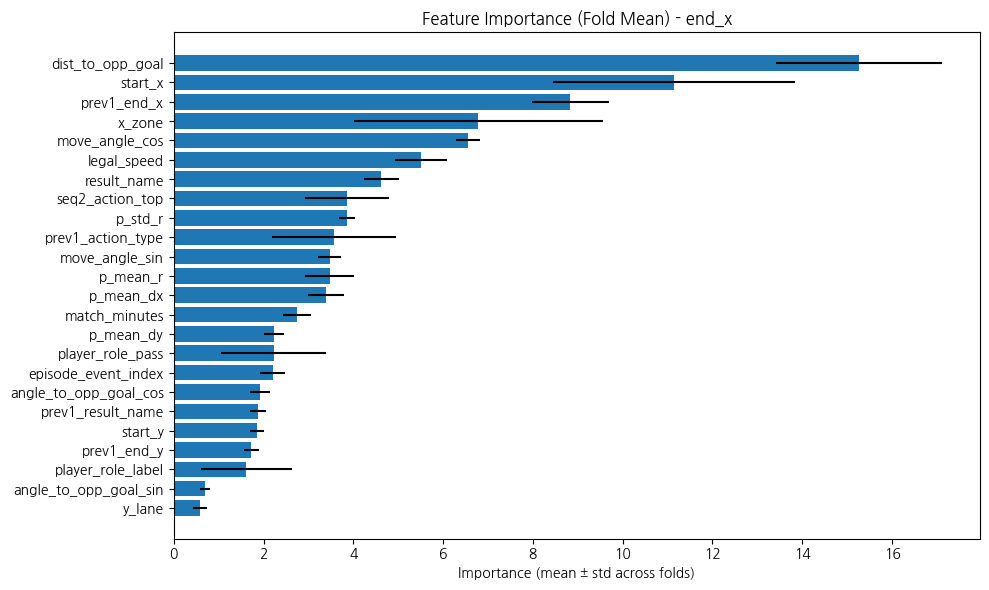

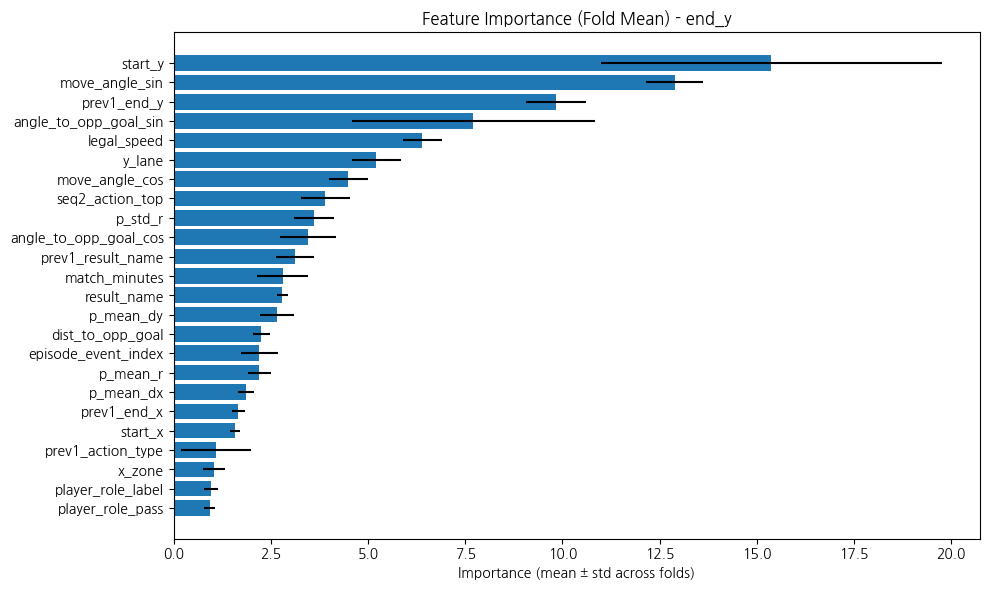

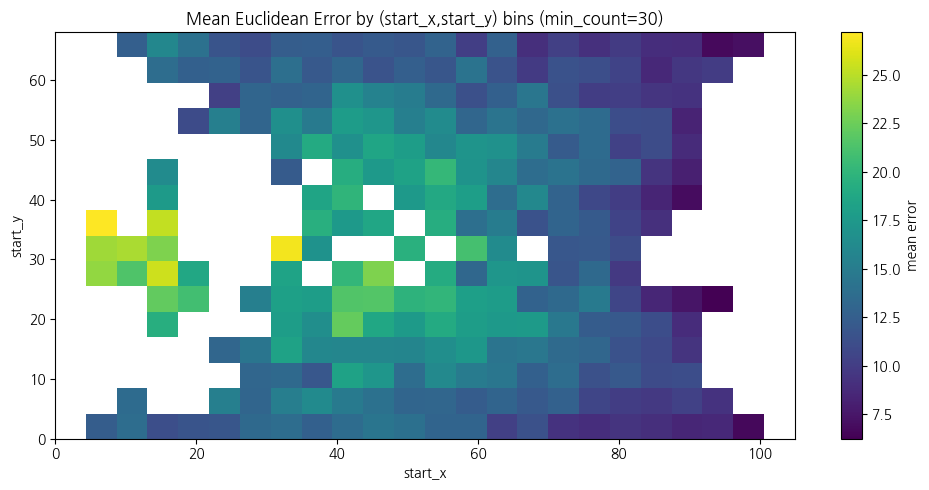

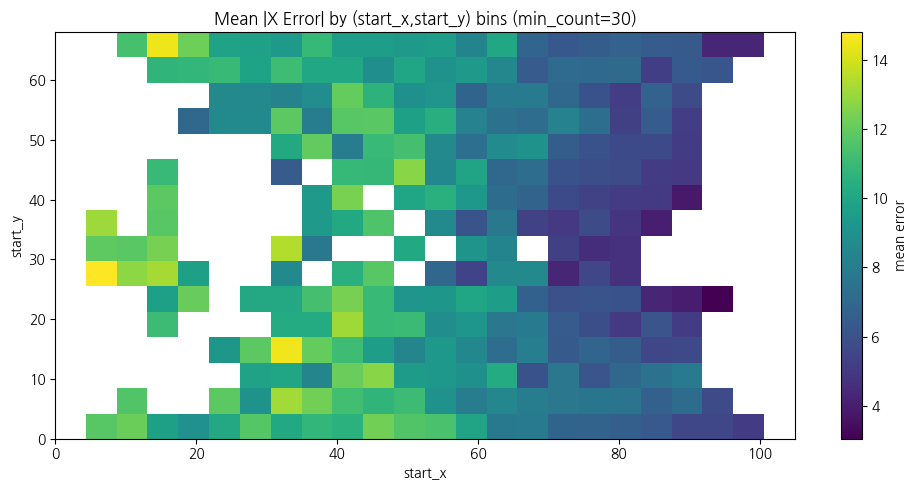

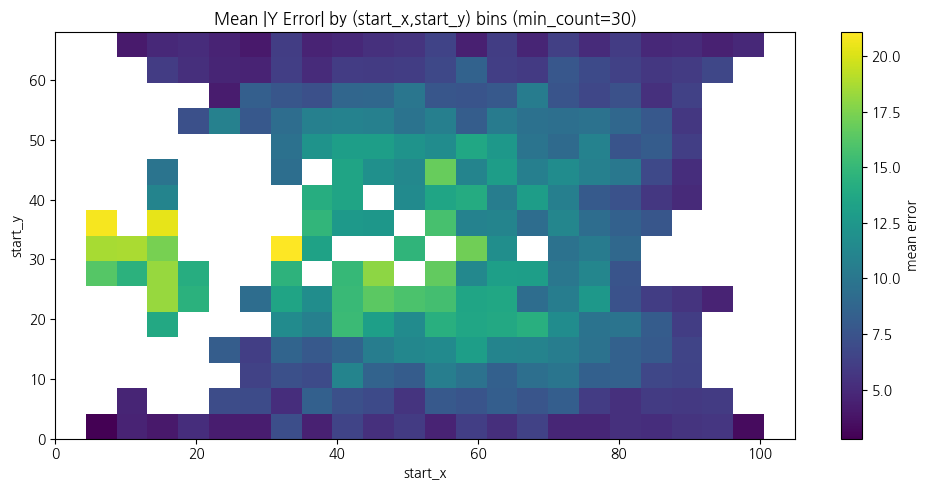

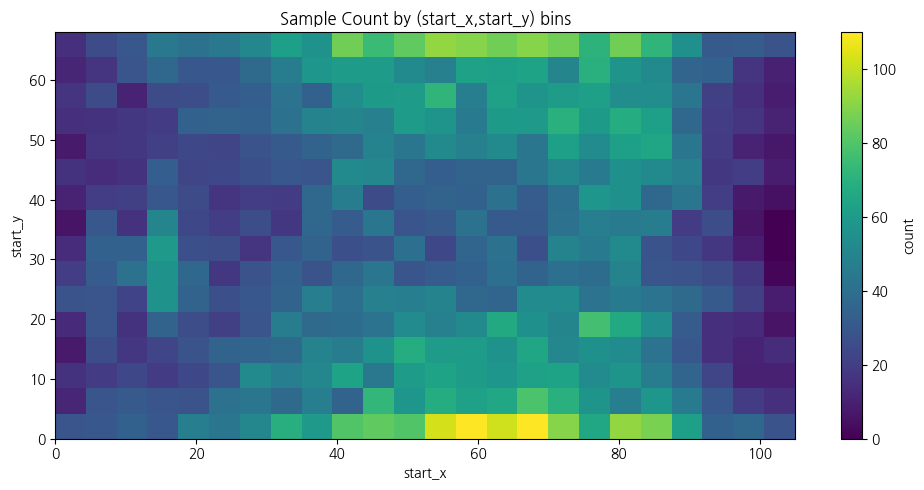

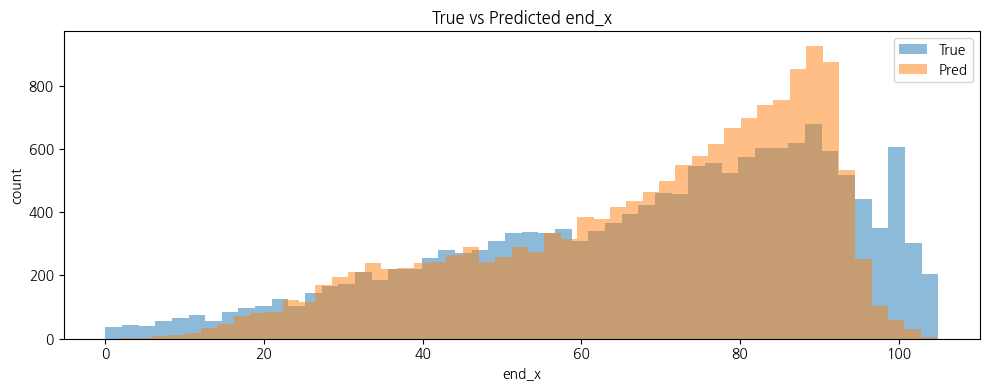

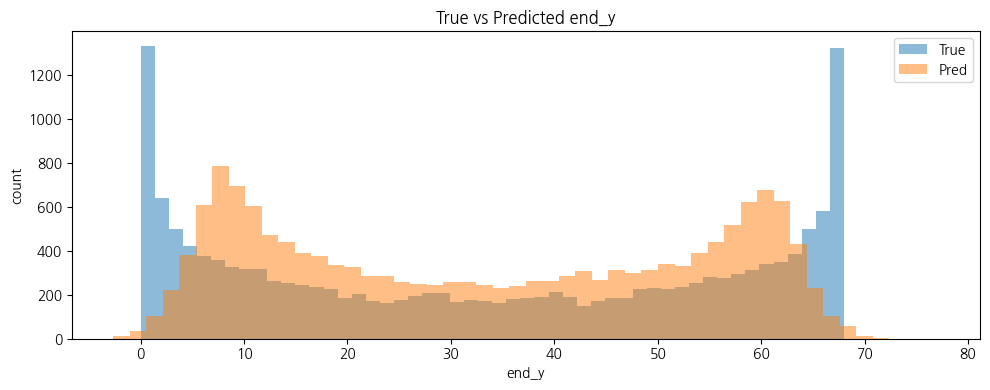

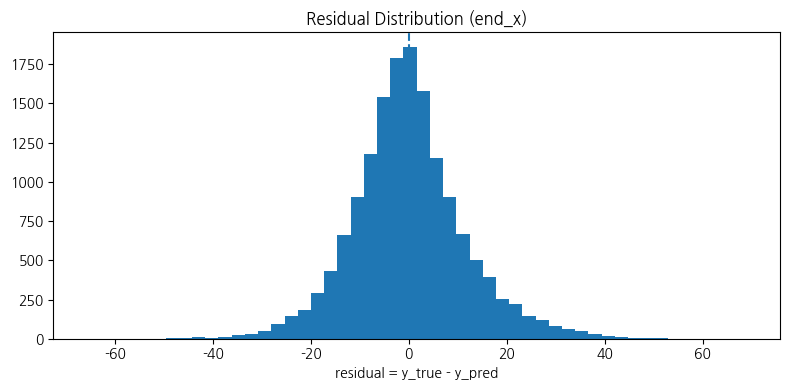

mean residual end_x: -0.054057695002592714


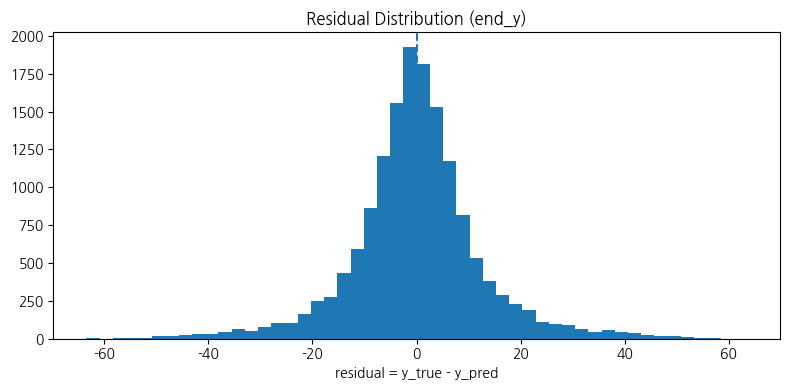

mean residual end_y: -0.017877338779825128

[Top 10 worst episodes by Euclidean error]


,game_episode,game_id,period_id,time_seconds,team_id,player_id,action_type,result_name,start_x,start_y,y_end_x,y_end_y,p_end_x,p_end_y,err_euc
10846,126422_17,126422,1,1155.500,4641,413677,Pass,Successful,16.924530,5.035944,101.286150,6.088176,32.237295,4.514152,69.066794
12513,126444_7,126444,1,459.867,4648,250100,Pass,Unsuccessful,42.208635,40.207856,0.641445,0.508001,46.620010,48.781254,66.665849
1907,126306_61,126306,2,942.567,4644,62086,Pass,Unsuccessful,41.625990,4.976172,103.988010,56.986108,59.668428,7.433811,66.480490
6271,126360_91,126360,2,3264.000,4220,287282,Pass,Successful,57.205365,0.170408,13.117125,13.549340,78.941317,14.465608,65.830569
5811,126355_107,126355,2,3124.166,4657,500484,Pass,Unsuccessful,29.307285,4.588028,62.893320,68.000000,45.932072,4.519549,65.707318
14410,126468_22,126468,1,1724.367,4640,500430,Pass,Unsuccessful,34.283445,65.665472,80.212335,0.000000,56.970983,61.151875,65.419510
13610,126458_28,126458,1,2015.133,4639,187316,Pass,Unsuccessful,16.854810,4.780944,11.890620,68.000000,52.180145,17.051226,64.954010
10282,126414_41,126414,2,74.356,316,407441,Pass,Unsuccessful,43.728510,9.114516,87.210690,68.000000,59.353768,9.898902,64.434041
3858,126330_47,126330,1,2585.400,4644,62082,Pass,Unsuccessful,18.789120,25.175028,18.664800,67.909764,71.366915,32.063160,63.737680
13910,126461_71,126461,2,947.067,4640,222332,Pass,Unsuccessful,5.347713,35.523336,37.753170,0.000000,41.274673,63.429479,63.527157


In [ ]:
report = build_training_result_eda_report(
    train_epi=train_epi,
    feature_cols=feature_cols,
    models_x=models_x,
    models_y=models_y,
    y_x=y_x, y_y=y_y,
    oof_pred_x=oof_pred_x,
    oof_pred_y=oof_pred_y,
    top_n_fi=25,
    min_count=30,
    show_top_error_table=True,
    top_k_errors=10,
)

## CSV 저장

In [ ]:
# test_pred_df -> sub_df로 이름만 맞추기
sub_df = test_pred_df.copy()

# sample_submission과 merge
sample_sub = pd.read_csv("./data/sample_submission.csv")

submission = sample_sub.drop(columns=["end_x", "end_y"], errors="ignore")
submission = submission.merge(sub_df, on="game_episode", how="left")

# 누락 여부 확인
print("sample_sub rows:", len(sample_sub))
print("pred rows:", len(sub_df))
print("missing end_x:", submission["end_x"].isna().sum(), "missing end_y:", submission["end_y"].isna().sum())

save_path = "./catboost_side1.csv"
submission[["game_episode", "end_x", "end_y"]].to_csv(save_path, index=False)
print("Saved:", save_path)

sample_sub rows: 2414
pred rows: 2414
missing end_x: 0 missing end_y: 0
Saved: ./catboost_side1.csv
